In [ ]:
from keras.layers import Dense, Flatten, Reshape, Conv2D, UpSampling2D, Cropping2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.layers.experimental import preprocessing
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def discriminator(latent_dim, initializer, info=False):
    discriminator = Sequential()
    discriminator.add(Dense(100, activation='relu',kernel_initializer=initializer,input_dim=latent_dim, bias_initializer=initializer))
    discriminator.add(Dense(500, activation='relu',kernel_initializer=initializer,bias_initializer=initializer))
    discriminator.add(Dense(1, activation="sigmoid",kernel_initializer=initializer,bias_initializer=initializer))

    if info:
        print(discriminator.summary())

    return discriminator
def encoder_decoder(input_shape, latent_dim, initializer, info=False, act="relu", dense_act=None):

    encoder = Sequential()
    encoder.add(Conv2D(32, (5, 5), padding="same", activation=act, input_shape=input_shape, kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Conv2D(64, (3, 3), activation=act, padding="same", kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Conv2D(128, (3, 3), activation=act, padding="same", kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Flatten())
    encoder.add(Dense(int(5376/2),kernel_initializer=initializer,activation=dense_act))
    encoder.add(Dense(latent_dim, activation="linear"))

    if info:
        print(encoder.summary())

    decoder = Sequential()
    decoder.add(Dense(2304,kernel_initializer=initializer,activation=dense_act,input_shape=(latent_dim,)))
    decoder.add(Dense(4608,kernel_initializer=initializer,activation=dense_act,input_shape=(2304,)))
    decoder.add(Reshape((encoder.layers[6].input_shape[1],encoder.layers[6].input_shape[2], 128)))
    decoder.add(Conv2D(128, (3, 3), activation=act, padding="same",kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(64, (3, 3), activation=act, padding="same", kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(32, (3, 3), activation=act, padding="same", kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(2, (3, 3), activation="linear", padding="same",kernel_initializer=initializer))
    decoder.add(Cropping2D(cropping=((3, 4), (3, 4))))

    decoder.build(input_shape)

    if info:
        print(decoder.summary())

    return encoder, decoder
def build_omata_encoder_decoder(input_shape, latent_dim, initializer,
                                info=False, act="elu", dense_act=None):
    encoder = Sequential()
    encoder.add(Conv2D(16, (3, 3), padding="same", activation=act,
                       input_shape=input_shape,
                       kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Conv2D(8, (3, 3), activation=act,
                       padding="same", kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Conv2D(8, (3, 3), activation=act,
                       padding="same", kernel_initializer=initializer))
    encoder.add(MaxPool2D(padding="same"))
    encoder.add(Flatten())
    encoder.add(Dense(latent_dim, activation="linear"))

    if info:
        print(encoder.summary())

    decoder = Sequential()
    decoder.add(Dense(288, input_dim=latent_dim,
                      kernel_initializer=initializer,
                      activation=dense_act))
    decoder.add(Reshape((encoder.layers[6].input_shape[1],
                         encoder.layers[6].input_shape[1], 8)))
    decoder.add(Conv2D(8, (3, 3), activation=act, padding="same",
                       kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(8, (3, 3), activation=act, padding="same",
                       kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(16, (3, 3), activation=act, padding="same",
                       kernel_initializer=initializer))
    decoder.add(UpSampling2D())
    decoder.add(Conv2D(1, (3, 3), activation="linear", padding="same",
                       kernel_initializer=initializer))
    # decoder.add(Cropping2D(cropping=((1, 0), (1, 1))))

    if info:
        print(decoder.summary())

    return encoder, decoder

In [ ]:
class CAE:
    """
    Convolutional autoencoder class
    """

    def __init__(self, encoder, decoder, optimizer, seed=None):
        self.encoder = encoder
        self.decoder = decoder
        self.seed = seed
        self.latent_dim = self.decoder.layers[0].input_shape[1]

        self.optimizer = optimizer

    def compile(self, input_shape, pi_loss=False):
        """
        Compile model
        Args:
            input_shape (tuple): Shape of input data
        """

        self.input_shape = input_shape

        grid = Input(shape=self.input_shape)
        encoded_repr = self.encoder(grid)
        gen_grid = self.decoder(encoded_repr)
        self.autoencoder = Model(grid, gen_grid)

        if pi_loss:
            loss_f = mse_PI(dx=2.2/55, dy=0.41/42)
        else:
            loss_f = "mse"

        self.autoencoder.compile(optimizer=self.optimizer,
                                 loss=loss_f,
                                 metrics=['accuracy'])

    def train(self, train_data, epochs, val_data=None, batch_size=128,
              val_batch_size=128, wandb_log=False):

        loss_val = None

        train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
        train_dataset = train_dataset.shuffle(buffer_size=train_data.shape[0],
                                              reshuffle_each_iteration=True,
                                              seed=self.seed).\
            batch(batch_size)

        if val_data is not None:
            val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
            val_dataset = val_dataset.shuffle(
                buffer_size=val_data.shape[0],
                reshuffle_each_iteration=True,
                seed=self.seed).\
                batch(val_batch_size)

        # Set up tensorboard logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/' + current_time + '/train'
        val_log_dir = 'logs/' + current_time + '/val'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        for epoch in range(epochs):
            loss_cum = 0
            acc_cum = 0
            for step, grids in enumerate(train_dataset):

                # Train the autoencoder reconstruction
                loss, acc = self.autoencoder.train_on_batch(grids, grids)
                loss_cum += loss
                acc_cum += acc

            # Average the loss and accuracy over the entire dataset
            loss = loss_cum/(step+1)
            acc = acc_cum/step

            with train_summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=epoch)
                tf.summary.scalar('accuracy', acc, step=epoch)

            # Calculate the accuracies on the validation set
            if val_data is not None:
                loss_val, acc_val = self.validate(val_dataset)

                with val_summary_writer.as_default():
                    tf.summary.scalar('loss', loss_val, step=epoch)
                    tf.summary.scalar('accuracy', acc_val, step=epoch)

            print("epochs:",epoch)

    def validate(self, val_dataset):

        loss_cum = 0
        acc_cum = 0
        step = 0
        for step, val_grids in enumerate(val_dataset):

            # Train the autoencoder reconstruction
            loss, acc = self.autoencoder.evaluate(val_grids, val_grids,
                                                  verbose=0)
            loss_cum += loss
            acc_cum += acc

        # Average the loss and accuracy over the entire dataset
        loss = loss_cum/(step+1)
        acc = acc_cum/(step+1)

        return loss, acc


    def predict(self, data):

        return self.autoencoder.predict(data)
class AAE:

    def __init__(self, encoder, decoder, discriminator, optimizer):
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.latent_dim = self.decoder.layers[0].input_shape[1]

        self.optimizer = optimizer

    def compile(self, input_shape):

        self.input_shape = input_shape

        grid = Input(shape=self.input_shape)
        encoded_repr = self.encoder(grid)
        gen_grid = self.decoder(encoded_repr)
        self.autoencoder = Model(grid, gen_grid)

        valid = self.discriminator(encoded_repr)
        self.encoder_discriminator = Model(grid, valid)

        self.discriminator.compile(optimizer=self.optimizer,loss='binary_crossentropy',metrics=['accuracy'])

        self.autoencoder.compile(optimizer=self.optimizer,loss='mse',metrics=['accuracy'])

        self.discriminator.trainable = False

        self.encoder_discriminator.compile(optimizer=self.optimizer,loss='binary_crossentropy',metrics=['accuracy'])

    def train(self, train_data, epochs, val_data=None, batch_size=32, val_batch_size=32, wandb_log=False):


        d_loss_val = g_loss_val = None

        train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
        train_dataset = train_dataset.shuffle(buffer_size=train_data.shape[0],reshuffle_each_iteration=None).batch(batch_size, drop_remainder=True)

        if val_data is not None:
            print("test-------------")
            val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
            val_dataset = val_dataset.shuffle(buffer_size=val_data.shape[0],reshuffle_each_iteration=True).batch(val_batch_size, drop_remainder=True)

        # Set up tensorboard logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/' + current_time + '/train'
        val_log_dir = 'logs/' + current_time + '/val'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        val_summary_writer = tf.summary.create_file_writer(val_log_dir)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # Reconstruction phase
            loss_cum = 0
            acc_cum = 0
            for step, grids in enumerate(train_dataset):
                # Train the autoencoder reconstruction
                loss, acc = self.autoencoder.train_on_batch(grids, grids)
                loss_cum += loss
                acc_cum += acc

            # Average the loss and accuracy over the entire dataset
            loss = loss_cum/(step+1)
            acc = acc_cum/(step+1)

            # Regularization phase
            d_loss_cum = 0
            g_loss_cum = 0
            for step, grids in enumerate(train_dataset):
                # Generate real and fake latent space. Fake latent space is
                # the normal distribution
                latent_fake = self.encoder.predict(grids)
                latent_real = np.random.normal(size=(batch_size,self.latent_dim))

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(latent_real,valid)[0]
                d_loss_fake = self.discriminator.train_on_batch(latent_fake,fake)[0]
                d_loss_cum += 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train generator
                g_loss_cum += self.encoder_discriminator.train_on_batch(grids, valid)[0]

            d_loss = d_loss_cum/(step+1)
            g_loss = g_loss_cum/(step+1)

            with train_summary_writer.as_default():
                tf.summary.scalar('loss - ae', loss, step=epoch)
                tf.summary.scalar('accuracy - ae', acc, step=epoch)
                tf.summary.scalar('loss - g', g_loss, step=epoch)
                tf.summary.scalar('loss - d', d_loss, step=epoch)
             # Calculate the accuracies on the validation set
            if val_data is not None:
                loss_val, acc_val, d_loss_val, g_loss_val = \
                    self.validate(val_dataset, val_batch_size)

                with val_summary_writer.as_default():
                    tf.summary.scalar('loss - ae', loss_val, step=epoch)
                    tf.summary.scalar('accuracy - ae', acc_val, step=epoch)
                    tf.summary.scalar('loss - g', g_loss_val, step=epoch)
                    tf.summary.scalar('loss - d', d_loss_val, step=epoch)
            print("tesp:",epoch)
    def validate(self, val_dataset, val_batch_size=128):
       

        # Adversarial ground truths
        valid = np.ones((val_batch_size, 1))
        fake = np.zeros((val_batch_size, 1))

        loss_cum = 0
        acc_cum = 0
        d_loss_cum = 0
        g_loss_cum = 0
        for step, val_grids in enumerate(val_dataset):

            loss, acc = self.autoencoder.evaluate(val_grids, val_grids,
                                                  verbose=0)
            loss_cum += loss
            acc_cum += acc

            latent_fake = self.encoder.predict(val_grids)
            latent_real = np.random.normal(size=(val_batch_size,
                                                 self.latent_dim))

            d_loss_real = self.discriminator.evaluate(latent_real,
                                                      valid, verbose=0)[0]
            d_loss_fake = self.discriminator.evaluate(latent_fake,
                                                      fake, verbose=0)[0]
            d_loss_cum += 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss_cum += \
                self.encoder_discriminator.evaluate(val_grids, valid,
                                                    verbose=0)[0]

        # Average the loss and accuracy over the entire dataset
        loss = loss_cum/(step+1)
        acc = acc_cum/(step+1)
        d_loss = d_loss_cum/(step+1)
        g_loss = g_loss_cum/(step+1)

        return loss, acc, d_loss, g_loss

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#snapshots_grids = np.load("./gdrive/MyDrive/ACSE9/star_info.npy")
snapshots_grids =np.load("./gdrive/MyDrive/ACSE9/starshape_ae_random_info_.npy")

In [ ]:
snapshots_grids.shape

(10000, 48, 48, 1)

In [ ]:
def Normalize(data):
  for i in range(10000):
    for j in range(48):
      for k in range(48):
        if data[i,j,k,0] !=0:
          data[i,j,k,0] = 1

In [ ]:
input_shape = (48, 48, 1)
snapshots = snapshots_grids

x_train = snapshots

initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.98, beta_2=0.999)

encoder, decoder = build_omata_encoder_decoder(input_shape, 30, initializer, info=True)
#discriminator = discriminator(30, initializer, info=True)


cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape, pi_loss=False)
cae.train(x_train,5000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


流式输出内容被截断，只能显示最后 5000 行内容。
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
epochs: 20
epochs: 21
epochs: 22
epochs: 23
epochs: 24
epochs: 25
epochs: 26
epochs: 27
epochs: 28
epochs: 29
epochs: 30
epochs: 31
epochs: 32
epochs: 33
epochs: 34
epochs: 35
epochs: 36
epochs: 37
epochs: 38
epochs: 39
epochs: 40
epochs: 41
epochs: 42
epochs: 43
epochs: 44
epochs: 45
epochs: 46
epochs: 47
epochs: 48
epochs: 49
epochs: 50
epochs: 51
epochs: 52
epochs: 53
epochs: 54
epochs: 55
epochs: 56
epochs: 57
epochs: 58
epochs: 59
epochs: 60
epochs: 61
epochs: 62
epochs: 63
epochs: 64
epochs: 65
epochs: 66
epochs: 67
epochs: 68
epochs: 69
epochs: 70
epochs: 71
epochs: 72
epochs: 73
epochs: 74
epochs: 75
epochs: 76
epochs: 77
epochs: 78
epochs: 79
epochs: 80
epochs: 81
epochs: 82
epochs: 83
epochs: 84
epochs: 85
epochs: 86
epochs: 87
epochs: 88
epoc

In [ ]:
snapshots_test = snapshots_grids
lat = cae.encoder.predict(snapshots_test)
result = cae.decoder.predict(lat)

<function matplotlib.pyplot.show>

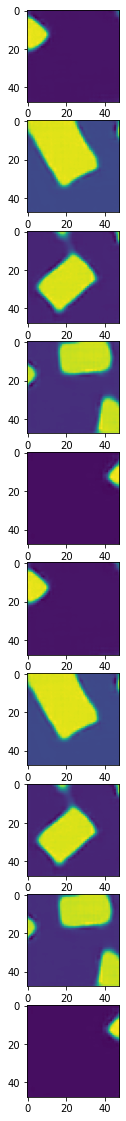

In [ ]:
plt.figure(figsize=(10,20))

for i in range(10):

  for j in range(1):

    plt.subplot(10,2,2 * i + j + 1)
    plt.imshow(result[i,:,:,j])
plt.show

(10000, 48, 48, 1)


<function matplotlib.pyplot.show>

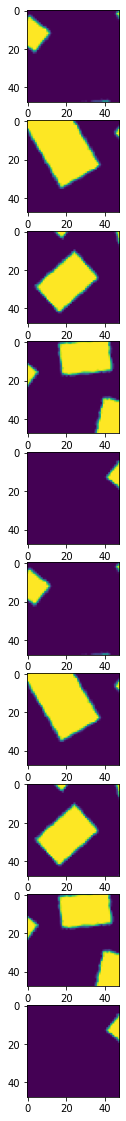

In [ ]:
#test = np.load("./gdrive/MyDrive/ACSE9/starshape_ae_random_info_.npy")
print(test.shape)
plt.figure(figsize=(10,20))

for i in range(10):

  for j in range(1):

    plt.subplot(10,2,2 * i + j + 1)
    plt.imshow(snapshots_grids[i,:,:,j])
plt.show

In [ ]:
# cae.encoder.save("./gdrive/MyDrive/ACSE9/my_model/encoder_info_400")
# cae.decoder.save("./gdrive/MyDrive/ACSE9/my_model/decoder_info_400")

cae.encoder.save("./gdrive/MyDrive/ACSE9/my_model/encoder_info_new")
cae.decoder.save("./gdrive/MyDrive/ACSE9/my_model/decoder_info_new")


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/ACSE9/my_model/encoder_info_new/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/ACSE9/my_model/encoder_info_new/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/ACSE9/my_model/decoder_info_new/assets


INFO:tensorflow:Assets written to: ./gdrive/MyDrive/ACSE9/my_model/decoder_info_new/assets
